In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import sklearn

%matplotlib inline

In [2]:
data = pd.read_csv("../input/loan.csv")
data.head(10)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.00,0.00,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.00,0.00,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.90,766.90,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,Nov-2004,3.0,NaN,NaN,9.0,0.0,7963.0,28.3,12.0,f,0.00,0.00,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-2015,161.03,NaN,Sep-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [3]:
data.shape

(887379, 74)

In [4]:
data.columns.sort_values()

Index(['acc_now_delinq', 'addr_state', 'all_util', 'annual_inc',
       'annual_inc_joint', 'application_type', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'desc', 'dti', 'dti_joint',
       'earliest_cr_line', 'emp_length', 'emp_title', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'home_ownership', 'id', 'il_util',
       'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths',
       'installment', 'int_rate', 'issue_d', 'last_credit_pull_d',
       'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status',
       'max_bal_bc', 'member_id', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_rcnt_il', 'next_pymnt_d', 'open_acc', 'open_acc_6m',
       'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m',
       'open_rv_24m', 'out_prncp', 'out_prncp_inv', 'policy_code', 'pub_rec',
       'purpose', 'pymnt_plan', 'recoveries', 'revol_bal', 'revol_util',
       'sub_grade'

# Analysis of loan status

In [5]:
data.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

In [6]:
data.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

*Issued* is not related to our predictions since it does not talk about fradulent behaviour. Similarly *In Grace Period* does not give information about fradulent behaviour since we don't know the future outcome.

In [7]:
# DF Transformed
data = data[~data.loan_status.isin(["Issued", "In Grace Period"])]

In [8]:
data.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [9]:
data.shape

(872666, 74)

In [10]:
bad_status = ["Charged Off", "Default", "Late (31-120 days)", "Late (16-30 days)", "Does not meet the credit policy. Status:Charged Off"]
good_status = ["Fully Paid", "Current", "Does not meet the credit policy. Status:Fully Paid"]

In [11]:
data["defaulter"] = data.loan_status.apply(lambda x: 1 if x in good_status else -1)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,defaulter
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [12]:
data.defaulter.value_counts()

 1    811490
-1     61176
Name: defaulter, dtype: int64

We have thus converted loan_status into a label called *defaulter* which we wish to predict. We have dropped *Issued* and *In Grace Period* for the reasons mentioned above.

# Filtering columns

The dataset contains a large number of columns, not all of which might be relevant. We try and remove certain columns that we feel does not contribute in any way to the predictions. The column descriptions are given in the data dictionary.

In [13]:
data.annual_inc.isna().sum()

4

In [14]:
data[data.annual_inc.isna()][["annual_inc", "annual_inc_joint", "defaulter"]]

,annual_inc,annual_inc_joint,defaulter
42449,NaN,NaN,1
42450,NaN,NaN,1
42480,NaN,NaN,1
42533,NaN,NaN,1


In [15]:
# DF Transformed
temp = data.shape[0]
data = data[data.annual_inc.notnull()]
print("Dropped:", temp - data.shape[0])

Dropped: 4


In [16]:
num_inc_joint_na = data.annual_inc_joint.isna().sum()
num_inc_joint_na

872218

In [17]:
inc_df = data[data.annual_inc_joint.notnull()][["annual_inc", "annual_inc_joint", "defaulter"]]
inc_df["joint_diff"] =  inc_df.annual_inc_joint - inc_df.annual_inc
inc_df.head(10)

,annual_inc,annual_inc_joint,defaulter,joint_diff
466914,29524.32,94348.32,1,64824.0
470869,86000.00,182000.00,1,96000.0
473690,89000.00,89000.00,1,0.0
474052,60000.00,95000.00,1,35000.0
474137,78000.00,111000.00,1,33000.0
474156,80000.00,118000.00,1,38000.0
474228,49000.00,49000.00,1,0.0
474428,45000.00,70000.00,1,25000.0
474531,70000.00,150000.00,1,80000.0
474776,37000.00,132000.00,1,95000.0


In [18]:
inc_df.joint_diff.describe()

count       444.000000
mean      49884.410878
std       35336.296830
min           0.000000
25%       25000.000000
50%       43848.500000
75%       65000.000000
max      265000.000000
Name: joint_diff, dtype: float64

In [19]:
data.shape[0] - num_inc_joint_na

444

In [20]:
inc_df.groupby("defaulter").joint_diff.count()

defaulter
-1      2
 1    442
Name: joint_diff, dtype: int64

Therefore *annual_inc_joint* is available only for 511 rows. Every row that contains *annual_inc_joint*  also contains *annual_inc* and the values differ significantly. Moreover only 2 cases are defaulters. It makes sense to drop the column due to its occurence and contribution to our predictions.

In [21]:
data.count().sort_values()

dti_joint                         442
annual_inc_joint                  444
verification_status_joint         444
il_util                         11609
mths_since_rcnt_il              12934
inq_last_12m                    13288
open_il_24m                     13288
total_bal_il                    13288
open_il_12m                     13288
open_rv_12m                     13288
open_rv_24m                     13288
max_bal_bc                      13288
all_util                        13288
inq_fi                          13288
total_cu_tl                     13288
open_il_6m                      13288
open_acc_6m                     13288
desc                           125511
mths_since_last_record         134447
mths_since_last_major_derog    217244
mths_since_last_delinq         425111
next_pymnt_d                   619691
tot_coll_amt                   802456
total_rev_hi_lim               802456
tot_cur_bal                    802456
emp_title                      822113
emp_length  

In [22]:
# DF Transformed
min_size = data.shape[0]*0.9
print(data.shape)
data = data.dropna(thresh=min_size, axis=1)
print(data.shape)

(872662, 75)
(872662, 53)


Removed columns with more than 10% null values.

In [23]:
data.columns.sort_values()

Index(['acc_now_delinq', 'addr_state', 'annual_inc', 'application_type',
       'collection_recovery_fee', 'collections_12_mths_ex_med', 'defaulter',
       'delinq_2yrs', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title',
       'funded_amnt', 'funded_amnt_inv', 'grade', 'home_ownership', 'id',
       'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate',
       'issue_d', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d',
       'loan_amnt', 'loan_status', 'member_id', 'open_acc', 'out_prncp',
       'out_prncp_inv', 'policy_code', 'pub_rec', 'purpose', 'pymnt_plan',
       'recoveries', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title',
       'tot_coll_amt', 'tot_cur_bal', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
       'total_rec_prncp', 'total_rev_hi_lim', 'url', 'verification_status',
       'zip_code'],
      dtype='object')

In [24]:
lst_to_be_removed = ['collection_recovery_fee', 'earliest_cr_line', 'funded_amnt_inv', 'inq_last_6mths', 'issue_d', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d', 'member_id', 'out_prncp_inv', 'recoveries', 'title', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'url']

In [25]:
# DF Transformed
data.drop(lst_to_be_removed, axis=1, inplace=True)

In [26]:
data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,defaulter
0,1077501,5000.0,5000.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Fully Paid,n,credit_card,860xx,AZ,27.65,0.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
1,1077430,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Charged Off,n,car,309xx,GA,1.00,0.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,-1
2,1077175,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Fully Paid,n,small_business,606xx,IL,8.72,0.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
3,1076863,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Fully Paid,n,other,917xx,CA,20.00,0.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1
4,1075358,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Current,n,other,972xx,OR,17.94,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1


In [27]:
data.shape

(872662, 35)

After analysing from the data-dictionary we removed columns that we felt weren't related to the output. We also removed columns that won't be available at the time of loan application.

# Analysis of attributes

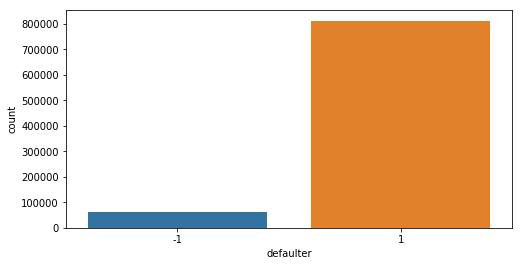

In [28]:
plt.figure(figsize=(8,4))
sns.countplot(x='defaulter', data=data)
plt.show()

In [29]:
data.defaulter.value_counts()

 1    811486
-1     61176
Name: defaulter, dtype: int64

Extremely skewed dataset. Might create problems when building models.

In [30]:
data.columns.sort_values()

Index(['acc_now_delinq', 'addr_state', 'annual_inc', 'application_type',
       'collections_12_mths_ex_med', 'defaulter', 'delinq_2yrs', 'dti',
       'emp_length', 'emp_title', 'funded_amnt', 'grade', 'home_ownership',
       'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt',
       'loan_status', 'open_acc', 'out_prncp', 'policy_code', 'pub_rec',
       'purpose', 'pymnt_plan', 'revol_bal', 'revol_util', 'sub_grade', 'term',
       'tot_coll_amt', 'tot_cur_bal', 'total_acc', 'total_rev_hi_lim',
       'verification_status', 'zip_code'],
      dtype='object')

In [31]:
to_remove = []

## collection_12_ex_med

In [32]:
data.collections_12_mths_ex_med.value_counts()

0.0     861136
1.0      10543
2.0        720
3.0         85
4.0         23
5.0          7
6.0          2
7.0          1
16.0         1
20.0         1
14.0         1
10.0         1
Name: collections_12_mths_ex_med, dtype: int64

In [33]:
temp = data[data['collections_12_mths_ex_med'] > 0]
temp.shape[0]

11385

In [34]:
len(temp[temp.defaulter == -1])

604

In [35]:
to_remove.append("collections_12_mths_ex_med")

Completely skewed attribute. Doesn't seem to contribute to output.

## dti (Debt-to-income ratio)

In [36]:
data.groupby('defaulter').dti.mean()

defaulter
-1    18.682776
 1    18.093967
Name: dti, dtype: float64

In [37]:
data.groupby('defaulter').dti.std()

defaulter
-1     8.094418
 1    17.798041
Name: dti, dtype: float64

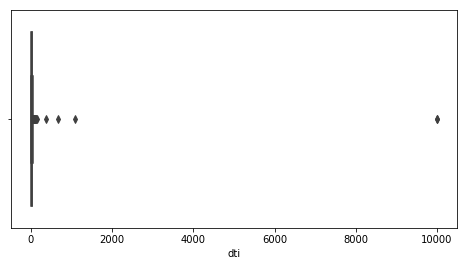

In [38]:
plt.figure(figsize=(8,4))
sns.boxplot("dti", data=data)
plt.show()

In [39]:
data.dti.describe()

count    872662.000000
mean         18.135244
std          17.296804
min           0.000000
25%          11.890000
50%          17.630000
75%          23.910000
max        9999.000000
Name: dti, dtype: float64

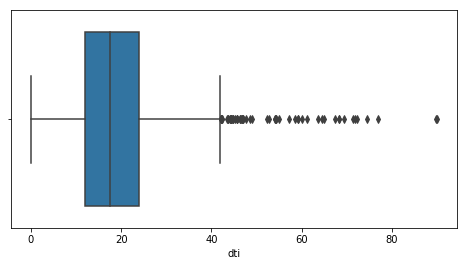

In [40]:
temp = data[data.dti < 100] # just greater than 75th percentile
plt.figure(figsize=(8,4))
sns.boxplot("dti", data=temp)
plt.show()

In [41]:
data.shape[0] - temp.shape[0]

10

In [42]:
temp.defaulter.value_counts()

 1    811476
-1     61176
Name: defaulter, dtype: int64

In [43]:
temp.groupby("defaulter").dti.mean()

defaulter
-1    18.682776
 1    18.066178
Name: dti, dtype: float64

In [44]:
temp.groupby("defaulter").dti.std()

defaulter
-1    8.094418
 1    8.311117
Name: dti, dtype: float64

The *dti* columns doesn't seem to contribute although logically it represents a good measure of loan repayment. The mean values are almost identical for both cases of defaulter. We can maybe analyze it by using it for building models.

# funded_amnt

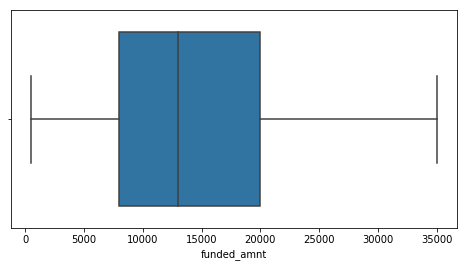

In [45]:
plt.figure(figsize=(8,4))
sns.boxplot("funded_amnt", data=data)
plt.show()

In [46]:
data.groupby("defaulter").funded_amnt.mean()

defaulter
-1    14703.684860
 1    14729.255773
Name: funded_amnt, dtype: float64

In [47]:
data.groupby("defaulter").funded_amnt.std()

defaulter
-1    8421.736501
 1    8422.697129
Name: funded_amnt, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


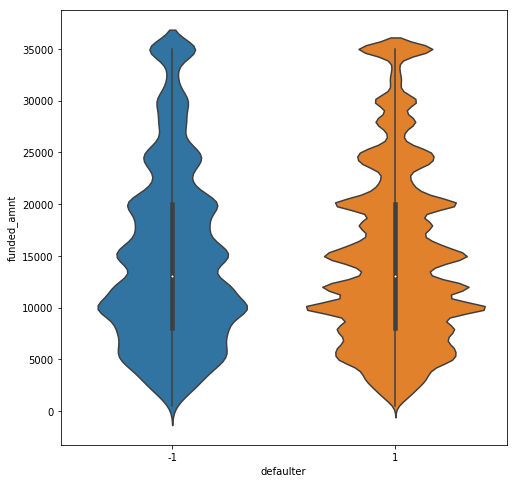

In [48]:
plt.figure(figsize=(8,8))
sns.violinplot(x='defaulter', y='funded_amnt', data=data)
plt.show()

In [49]:
to_remove.append('funded_amnt')

Values seem to be distributed similarly across both defaulter values. Thus it does not seem to be contributing to the result.

## initial_list_status

In [50]:
data.groupby('defaulter').initial_list_status.value_counts()

defaulter  initial_list_status
-1         f                       41865
           w                       19311
 1         f                      410938
           w                      400548
Name: initial_list_status, dtype: int64

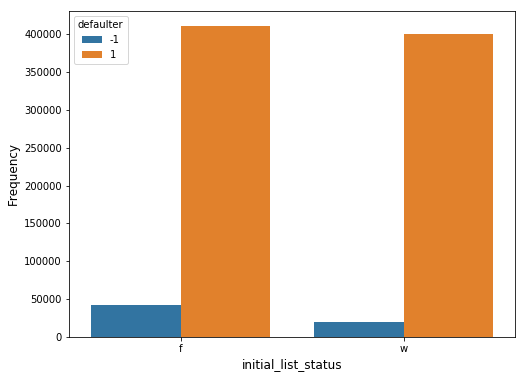

In [51]:
plt.figure(figsize=(8,6))
sns.countplot(x='initial_list_status', hue='defaulter', data=data)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('initial_list_status', fontsize=12)
plt.show()

Probability of being a defaulter is slightly more incase of fractional loans ('f') than whole loans ('w'). It seems to be contributing slightly. This feature seems to be useful considering our skewed dataset.

## int_rate (Interest rate)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


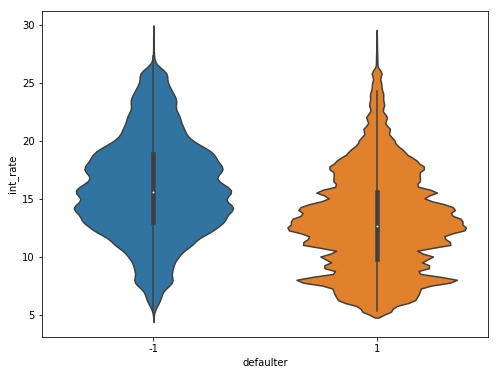

In [52]:
plt.figure(figsize=(8,6))
sns.violinplot(x='defaulter', y='int_rate', data=data)
plt.show()

In [53]:
data.groupby("defaulter").int_rate.mean()

defaulter
-1    15.986362
 1    13.032407
Name: int_rate, dtype: float64

In [54]:
data.groupby("defaulter").int_rate.std()

defaulter
-1    4.297696
 1    4.313445
Name: int_rate, dtype: float64

This feature seems important since a higher interest rate seems to lead to more defaulters.

## policy_code

In [55]:
data.policy_code.value_counts()

1.0    872662
Name: policy_code, dtype: int64

In [56]:
to_remove.append("policy_code")

Clearly not useful since it has only one value for all columns.

# pub_rec

In [57]:
data.pub_rec.value_counts()

0.0     739465
1.0     111165
2.0      14519
3.0       4396
4.0       1527
5.0        739
6.0        372
7.0        167
8.0        111
9.0         48
10.0        41
11.0        22
12.0        15
13.0        12
15.0         6
18.0         5
16.0         5
21.0         4
17.0         3
14.0         2
19.0         2
49.0         2
40.0         1
26.0         1
63.0         1
22.0         1
28.0         1
86.0         1
34.0         1
23.0         1
54.0         1
Name: pub_rec, dtype: int64

In [58]:
data.groupby("pub_rec").defaulter.value_counts()

pub_rec  defaulter
0.0       1           686523
         -1            52942
1.0       1           104048
         -1             7117
2.0       1            13755
         -1              764
3.0       1             4187
         -1              209
4.0       1             1450
         -1               77
5.0       1              703
         -1               36
6.0       1              357
         -1               15
7.0       1              162
         -1                5
8.0       1              110
         -1                1
9.0       1               44
         -1                4
10.0      1               41
11.0      1               21
         -1                1
12.0      1               13
         -1                2
13.0      1               12
14.0      1                2
15.0      1                6
16.0      1                5
17.0      1                3
18.0      1                5
19.0      1                2
21.0      1                4
22.0      1             

In [59]:
to_remove.append("pub_rec")

The probability of a defaulter given the pub_rec value doesn't seem to be much different than just the probability of the class. The higher values having defaulter as 1 might be because of the skewed data set.

## pymnt_plan

In [60]:
data.pymnt_plan.value_counts()

n    872652
y        10
Name: pymnt_plan, dtype: int64

In [61]:
data.groupby("pymnt_plan").defaulter.value_counts()

pymnt_plan  defaulter
n            1           811481
            -1            61171
y           -1                5
             1                5
Name: defaulter, dtype: int64

In [62]:
to_remove.append("pymnt_plan")

The attribute values are skewed and the distribution of defaulters is also uniform. This attribute doesn't seem to be useful.

## revol_util

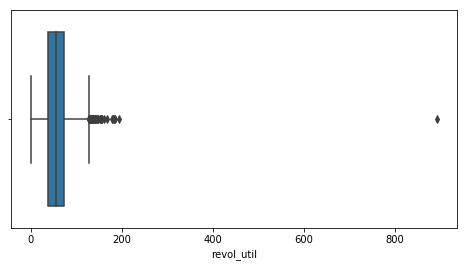

In [63]:
plt.figure(figsize=(8,4))
sns.boxplot("revol_util", data=data)
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


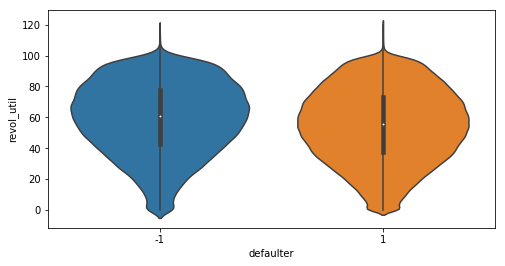

In [64]:
temp = data[data.revol_util < 120] # Just near whisker end

plt.figure(figsize=(8,4))
sns.violinplot(x='defaulter', y='revol_util', data=temp) # We use 
plt.show()

In [65]:
data.groupby("defaulter").revol_util.mean()

defaulter
-1    59.139876
 1    54.759365
Name: revol_util, dtype: float64

In [66]:
data.groupby("defaulter").revol_util.std()

defaulter
-1    23.529820
 1    23.817657
Name: revol_util, dtype: float64

In [67]:
to_remove.append("revol_util")

Even this attribute doesn't seem to affect the condtional distribution of defaulter.

## sub_grade

In [68]:
len(data.sub_grade.unique())

35

In [69]:
data.sub_grade.value_counts()

B3    55502
B4    54823
C1    52445
C2    51377
C3    49281
B2    48069
B5    48021
C4    47949
B1    44351
A5    44272
C5    40449
D1    35605
A4    34152
D2    29239
D3    26043
D4    25096
A3    23198
A1    22565
A2    22198
D5    20969
E1    17911
E2    16644
E3    13831
E4    11485
E5     9333
F1     7056
F2     5265
F3     4315
F4     3344
F5     2518
G1     1831
G2     1361
G3      961
G4      641
G5      562
Name: sub_grade, dtype: int64

In [70]:
data.groupby("sub_grade").defaulter.value_counts()

sub_grade  defaulter
A1          1           22338
           -1             227
A2          1           21831
           -1             367
A3          1           22700
           -1             498
A4          1           33220
           -1             932
A5          1           42998
           -1            1274
B1          1           42797
           -1            1554
B2          1           46014
           -1            2055
B3          1           52722
           -1            2780
B4          1           51787
           -1            3036
B5          1           45230
           -1            2791
C1          1           49141
           -1            3304
C2          1           47953
           -1            3424
C3          1           45805
           -1            3476
C4          1           44411
           -1            3538
C5          1           37024
           -1            3425
                        ...  
E1          1           15889
           -1      

In [71]:
data.groupby("grade").sub_grade.value_counts()

grade  sub_grade
A      A5           44272
       A4           34152
       A3           23198
       A1           22565
       A2           22198
B      B3           55502
       B4           54823
       B2           48069
       B5           48021
       B1           44351
C      C1           52445
       C2           51377
       C3           49281
       C4           47949
       C5           40449
D      D1           35605
       D2           29239
       D3           26043
       D4           25096
       D5           20969
E      E1           17911
       E2           16644
       E3           13831
       E4           11485
       E5            9333
F      F1            7056
       F2            5265
       F3            4315
       F4            3344
       F5            2518
G      G1            1831
       G2            1361
       G3             961
       G4             641
       G5             562
Name: sub_grade, dtype: int64

In [72]:
temp = pd.crosstab(data.sub_grade, data.defaulter)
temp.head()

defaulter,-1,1
sub_grade,,
A1,227,22338
A2,367,21831
A3,498,22700
A4,932,33220
A5,1274,42998


In [73]:
temp["ratio"] = temp[-1] / temp[1]
temp.head()

defaulter,-1,1,ratio
sub_grade,,,
A1,227,22338,0.010162
A2,367,21831,0.016811
A3,498,22700,0.021938
A4,932,33220,0.028055
A5,1274,42998,0.029629


In [74]:
temp["sub_grade"] = temp.index
temp.head()

defaulter,-1,1,ratio,sub_grade
sub_grade,,,,
A1,227,22338,0.010162,A1
A2,367,21831,0.016811,A2
A3,498,22700,0.021938,A3
A4,932,33220,0.028055,A4
A5,1274,42998,0.029629,A5


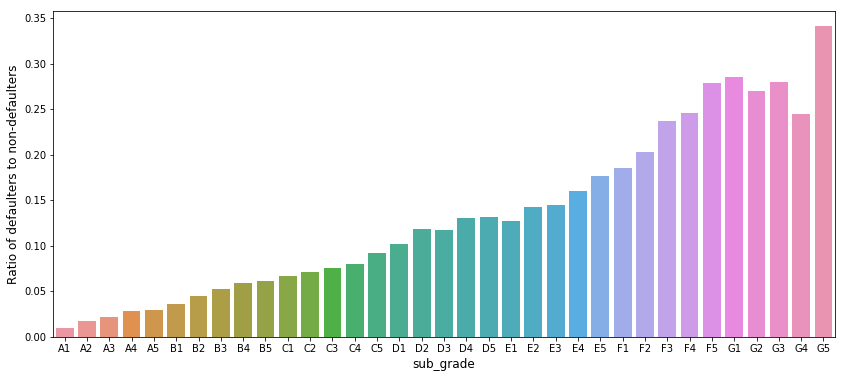

In [75]:
plt.figure(figsize=(14,6))
sns.barplot(x='sub_grade', y="ratio", data=temp)
plt.ylabel('Ratio of defaulters to non-defaulters', fontsize=12)
plt.xlabel('sub_grade', fontsize=12)
plt.show()

sub_grade seems to be an important column since the ratio of defaulters to non-defaulters increases with decrease in subgrade. We can compare it with grade when we build models, maybe with respect to measures like info gain.

## application_type

In [76]:
data.groupby("application_type").defaulter.value_counts()

application_type  defaulter
INDIVIDUAL         1           811044
                  -1            61174
JOINT              1              442
                  -1                2
Name: defaulter, dtype: int64

In [77]:
to_remove.append("application_type")

There doesn't seem to be any relation between defaulter and application_type.

## delinq_2yrs

In [78]:
len(data.delinq_2yrs.unique())

30

In [79]:
data.groupby("delinq_2yrs").defaulter.value_counts()

delinq_2yrs  defaulter
0.0           1           655933
             -1            49733
1.0           1           103540
             -1             7518
2.0           1            30545
             -1             2317
3.0           1            10860
             -1              838
4.0           1             4859
             -1              348
5.0           1             2461
             -1              187
6.0           1             1344
             -1               90
7.0           1              697
             -1               57
8.0           1              426
             -1               25
9.0           1              258
             -1               16
10.0          1              171
             -1               13
11.0          1              113
             -1                6
12.0          1               76
             -1               13
13.0          1               57
             -1                4
14.0          1               43
             -1     

In [80]:
temp = pd.crosstab(data.delinq_2yrs, data.defaulter)
temp.head()

defaulter,-1,1
delinq_2yrs,,
0.0,49733,655933
1.0,7518,103540
2.0,2317,30545
3.0,838,10860
4.0,348,4859


In [81]:
temp["ratio"] = temp.apply(lambda x: (x[-1]/x[1]), axis=1)
temp.head()

defaulter,-1,1,ratio
delinq_2yrs,,,
0.0,49733,655933,0.075820
1.0,7518,103540,0.072610
2.0,2317,30545,0.075855
3.0,838,10860,0.077164
4.0,348,4859,0.071620


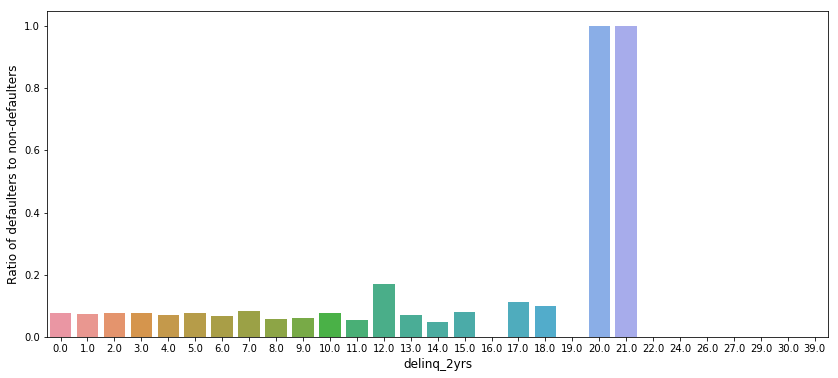

In [82]:
temp["delinq"] = temp.index
plt.figure(figsize=(14,6))
sns.barplot(x='delinq', y="ratio", data=temp)
plt.ylabel('Ratio of defaulters to non-defaulters', fontsize=12)
plt.xlabel('delinq_2yrs', fontsize=12)
plt.show()

In [83]:
to_remove.append("delinq_2yrs")

The probability of a defaulter conditioned on the delinq_2yrs value is almost same as just the probability of a defaulter suggesting that the gain is less. Wherever the probability is high the number of instances are extremely low i.e. around 1-10

## emp_title

In [84]:
len(data.emp_title.unique())

295931

In [85]:
data.emp_title.value_counts()

Teacher                                     13158
Manager                                     11011
Registered Nurse                             5421
RN                                           5261
Owner                                        5243
Supervisor                                   4885
Sales                                        4132
Project Manager                              3918
Driver                                       3498
Office Manager                               3465
General Manager                              3117
Director                                     3107
manager                                      3074
teacher                                      2876
owner                                        2778
Engineer                                     2619
President                                    2524
driver                                       2382
Vice President                               2304
Attorney                                     2103


In [86]:
data[data.emp_title.isna()].defaulter.value_counts()

 1    46029
-1     4520
Name: defaulter, dtype: int64

The null rows can't be dropped due to high number of defaulters. But the column logically contributes to the final output.

## purpose

In [87]:
data.purpose.value_counts()

debt_consolidation    515421
credit_card           202961
home_improvement       50969
other                  42100
major_purchase         16968
small_business         10186
car                     8742
medical                 8393
moving                  5319
vacation                4642
house                   3633
wedding                 2344
renewable_energy         561
educational              423
Name: purpose, dtype: int64

In [88]:
data.groupby('purpose').defaulter.value_counts()

purpose             defaulter
car                  1             8186
                    -1              556
credit_card          1           192356
                    -1            10605
debt_consolidation   1           477811
                    -1            37610
educational          1              335
                    -1               88
home_improvement     1            47783
                    -1             3186
house                1             3253
                    -1              380
major_purchase       1            15799
                    -1             1169
medical              1             7645
                    -1              748
moving               1             4755
                    -1              564
other                1            38247
                    -1             3853
renewable_energy     1              497
                    -1               64
small_business       1             8484
                    -1             1702
vacation  

In [89]:
temp = pd.crosstab(data.purpose, data.defaulter)
temp["ratio"] = temp.apply(lambda x: (x[-1]/x[1]), axis=1)
temp["purpose"] = temp.index
temp.head()

defaulter,-1,1,ratio,purpose
purpose,,,,
car,556,8186,0.067921,car
credit_card,10605,192356,0.055132,credit_card
debt_consolidation,37610,477811,0.078713,debt_consolidation
educational,88,335,0.262687,educational
home_improvement,3186,47783,0.066676,home_improvement


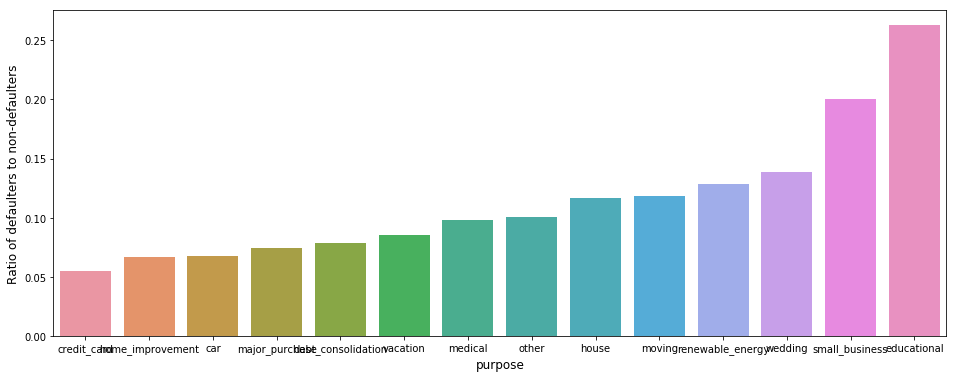

In [90]:
plt.figure(figsize=(16,6))
sns.barplot(x='purpose', y="ratio", data=temp, order=temp.sort_values("ratio").purpose.values)
plt.ylabel('Ratio of defaulters to non-defaulters', fontsize=12)
plt.xlabel('purpose', fontsize=12)
plt.show()

The ratio of defaulters conditioned on the purpose value is quite high which indicates that this is a good column.

## revol_bal

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


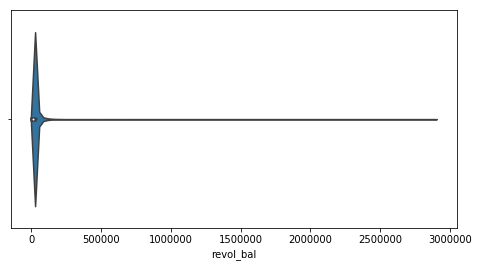

In [91]:
plt.figure(figsize=(8,4))
sns.violinplot("revol_bal", data=data) # We use 
plt.show()

In [92]:
data.revol_bal.describe()

count    8.726620e+05
mean     1.692038e+04
std      2.243014e+04
min      0.000000e+00
25%      6.449000e+03
50%      1.187900e+04
75%      2.083200e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

In [93]:
data.groupby("defaulter").revol_bal.mean()

defaulter
-1    15250.714169
 1    17046.248035
Name: revol_bal, dtype: float64

In [94]:
data.groupby("defaulter").revol_bal.std()

defaulter
-1    19671.465599
 1    22619.489624
Name: revol_bal, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


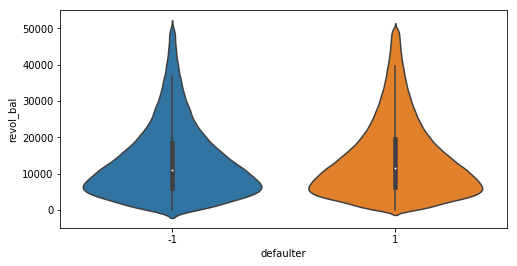

In [95]:
plt.figure(figsize=(8,4))
sns.violinplot(y="revol_bal", x="defaulter", data=data[data.revol_bal < 50000]) # We remove outliers in the plot
plt.show()

In [96]:
to_remove.append("revol_bal")

There doesn't seem to be any difference in the distribution. This feature doesn't seem too useful.

# Short Summary

In [97]:
to_remove.append("loan_status")
print(to_remove)

['collections_12_mths_ex_med', 'funded_amnt', 'policy_code', 'pub_rec', 'pymnt_plan', 'revol_util', 'application_type', 'delinq_2yrs', 'revol_bal', 'loan_status']


In [98]:
data.isna().sum()

id                                0
loan_amnt                         0
funded_amnt                       0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                     50549
emp_length                    43956
home_ownership                    0
annual_inc                        0
verification_status               0
loan_status                       0
pymnt_plan                        0
purpose                           0
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      25
open_acc                         25
pub_rec                          25
revol_bal                         0
revol_util                      493
total_acc                        25
initial_list_status               0
out_prncp                         0
collections_12_mths_ex_med  

In [99]:
y = len(data[data.defaulter == -1])

def defaulter_in_null(df, attr):
    temp = df[df[attr].isna()]
    x = len(temp[df.defaulter == -1])
    return (x, x/len(temp), x/y)
    
attrs = [
    "total_rev_hi_lim",
    "tot_cur_bal",
    "tot_coll_amt",
    "acc_now_delinq",
    "collections_12_mths_ex_med",
    "total_acc",
    "revol_util",
    "pub_rec",
    "open_acc",
    "delinq_2yrs",
    "emp_length",
    "emp_title"
]

for i in attrs:
    print(defaulter_in_null(data, i))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match D

(10946, 0.1559126000626727, 0.17892637635674122)
(10946, 0.1559126000626727, 0.17892637635674122)
(10946, 0.1559126000626727, 0.17892637635674122)
(3, 0.12, 4.9038838760298155e-05)
(28, 0.19858156028368795, 0.00045769582842944943)
(3, 0.12, 4.9038838760298155e-05)
(65, 0.13184584178498987, 0.0010625081731397933)
(3, 0.12, 4.9038838760298155e-05)
(3, 0.12, 4.9038838760298155e-05)
(3, 0.12, 4.9038838760298155e-05)
(3472, 0.07898807898807898, 0.05675428272525173)
(4520, 0.08941818829254783, 0.07388518373218256)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


We'll need to handle these null values in a proper way.

## term

In [100]:
data.term = data.term.apply(lambda x: int(re.search(r'\d+', x).group()))

In [101]:
data.groupby("term").defaulter.value_counts()

term  defaulter
36     1           572208
      -1            38956
60     1           239278
      -1            22220
Name: defaulter, dtype: int64

Once again there doesn't seem to be an increase in the probability of a defaulter conditioned on the value of *term*.

## verification_status

In [102]:
data.groupby("verification_status").defaulter.value_counts()

verification_status  defaulter
Not Verified          1           246573
                     -1            15991
Source Verified       1           304184
                     -1            20015
Verified              1           260729
                     -1            25170
Name: defaulter, dtype: int64

In [103]:
data.emp_length.unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [104]:
temp = pd.crosstab(data.verification_status, data.defaulter)
temp["ratio"] = temp.apply(lambda x: (x[-1]/x[1]), axis=1)
temp["vf"] = temp.index
temp.head()

defaulter,-1,1,ratio,vf
verification_status,,,,
Not Verified,15991,246573,0.064853,Not Verified
Source Verified,20015,304184,0.065799,Source Verified
Verified,25170,260729,0.096537,Verified


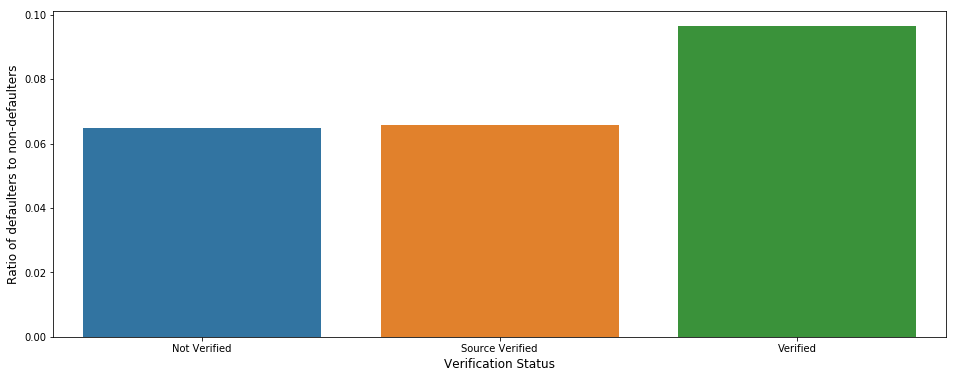

In [105]:
plt.figure(figsize=(16,6))
sns.barplot(x='vf', y="ratio", data=temp, order=temp.sort_values("ratio").vf.values)
plt.ylabel('Ratio of defaulters to non-defaulters', fontsize=12)
plt.xlabel('Verification Status', fontsize=12)
plt.show()

Considering that the ratio of defaulters to non-defaulters is 0.7 we don't gain much information by conditioning on verification_status.

# Train Test Split

In [106]:
train, test = sklearn.model_selection.train_test_split(data, random_state=100, shuffle=True, test_size=0.3)

In [107]:
print("Train:", train.shape)
print("Test:", test.shape)

Train: (610863, 35)
Test: (261799, 35)


In [108]:
print("Train Defaulters:", len(train[train.defaulter == -1]))
print("Test Defaulters:", len(test[test.defaulter == -1]))

Train Defaulters: 42745
Test Defaulters: 18431


In [ ]:
train.to_csv("train.csv")
test.to_csv("test.csv")